__Object detection. Обучение модели одностадийной детекции, на основе модели Yolo-V1__
--

In [12]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from src.models.yolo_v1 import YoloV1
from src.models.backbone import resnet50
from torchvision.transforms import v2
from src.utils.nms import non_max_suppression
from PIL import Image
from matplotlib.patches import Rectangle
from pathlib import Path

In [2]:
first_model = torch.load("models\\yolov1_first_stage_46.plt", map_location="cpu", weights_only=False)
firs_model_data = first_model["history_of_education"]

__1) Обучение heed и neck__
--
Обучение модели проводилось с замороженным backbone (resnet50), 
обучение проводилось на наборе данных Pascal VOC 2012.\
Графики функции потерь, метрики "mean average precision", шага обучения:

__Графики функции потерь:__

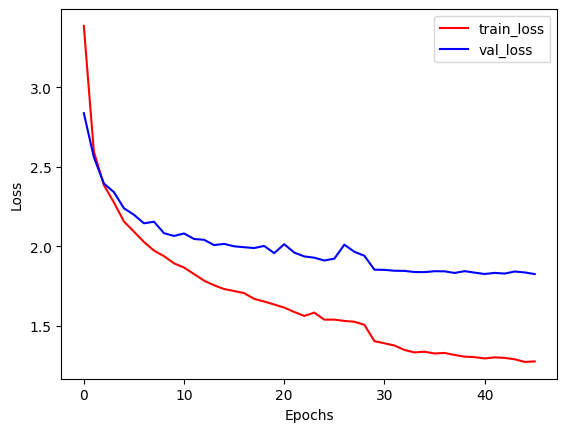

In [3]:
plt.plot(np.array(firs_model_data["loss"]["train"])[:,0], c="r", label="train_loss")
plt.plot(np.array(firs_model_data["loss"]["val"])[:,0], c="b", label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()
plt.close()

__Граффики метрики "mean average precision":__

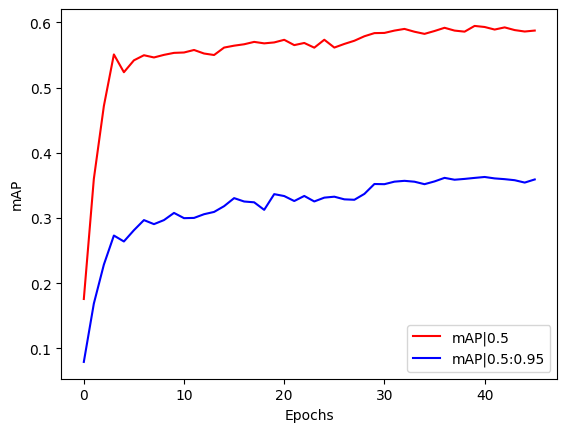

In [4]:
plt.plot(np.array(firs_model_data["mAP"])[:,0], c="r", label="mAP|0.5")
plt.plot(np.array(firs_model_data["mAP"])[:,1], c="b", label="mAP|0.5:0.95")
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.legend()
plt.show()
plt.close()

__График шага обучения:__

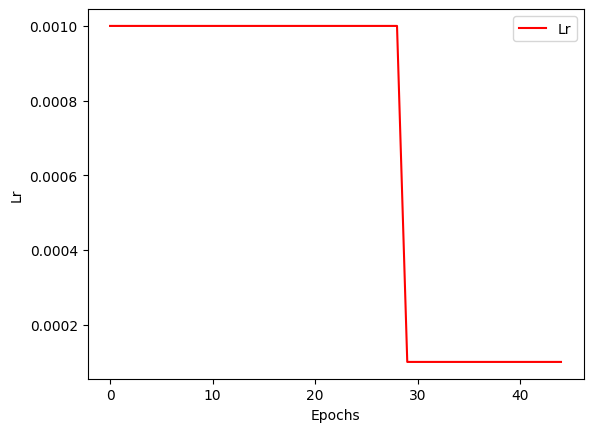

In [6]:
plt.plot(np.array(firs_model_data["lr_list"])[:,0], c="r", label="Lr")
plt.xlabel("Epochs")
plt.ylabel("Lr")
plt.legend()
plt.show()
plt.close()

__2) Просмотр результатов работы модели__
--

In [7]:
model = YoloV1(
    S=7, B=2, num_cls=20,
    backbone=resnet50(), bn=True,
    use_layer="conv1x1", act="leakyrelu"
).to("cpu")

model.load_state_dict(first_model["model_state_dict"])

transforms = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(dtype=torch.uint8, scale=True),
                v2.Resize(size=(448,448)),
                v2.ToDtype(dtype=torch.float32, scale=True),
                v2.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            ])

In [8]:
def get_rect(box: torch.Tensor, color="r"):
    return Rectangle(
        xy=(box[0], box[1]),
        width=(box[2] - box[0]),
        height=(box[3] - box[1]),
        linewidth=1,
        edgecolor=color,
        facecolor="none"
    )

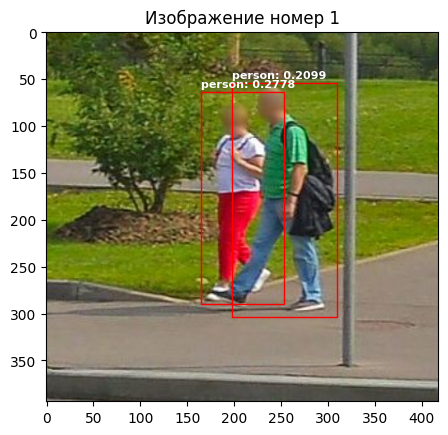

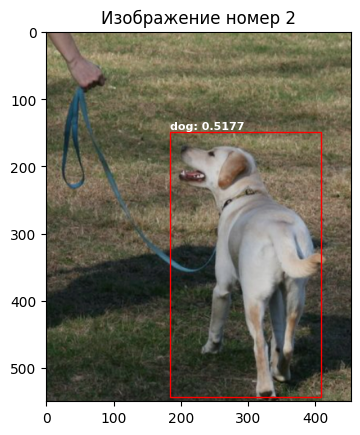

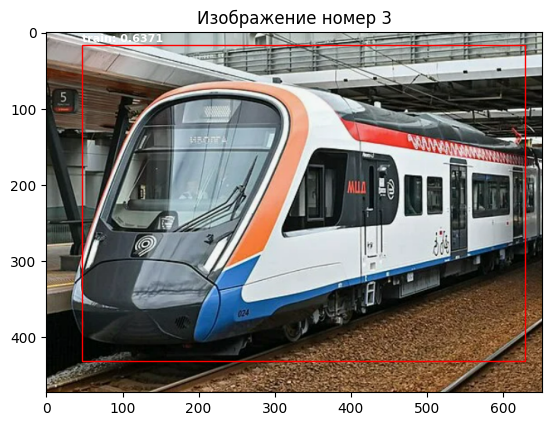

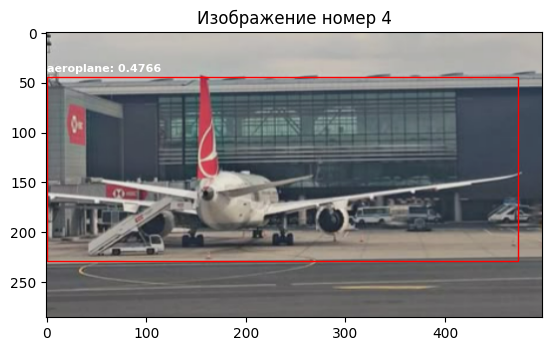

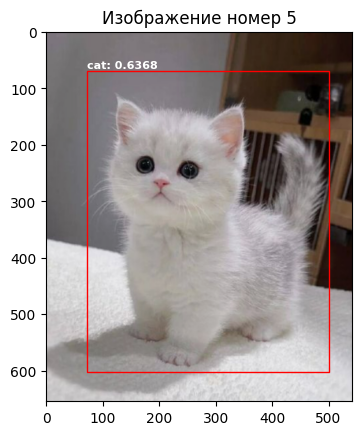

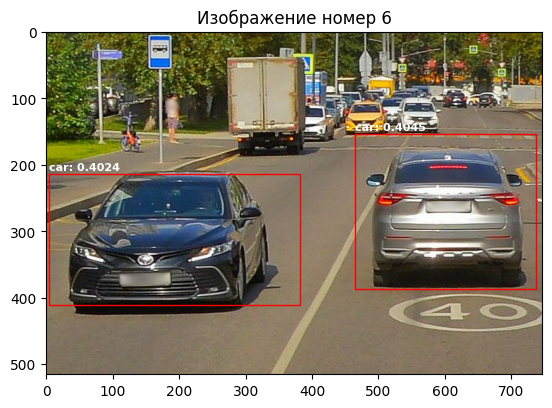

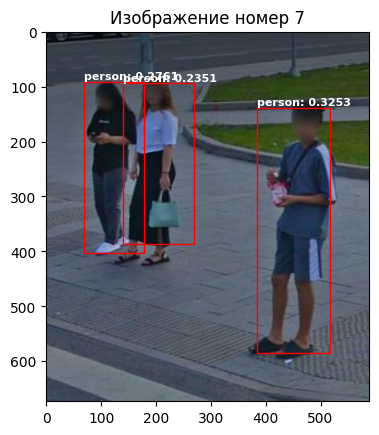

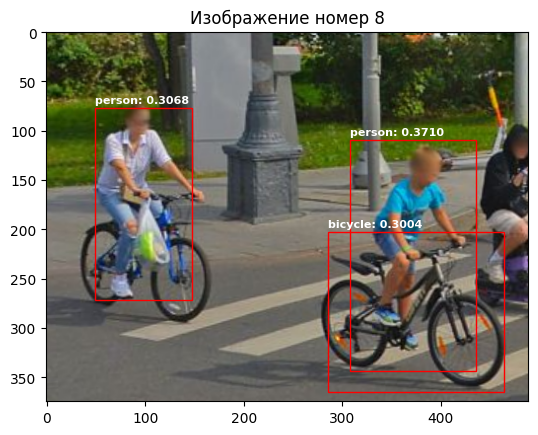

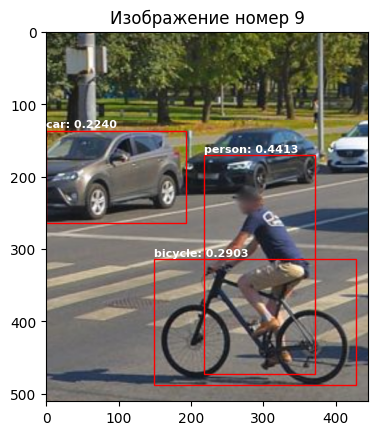

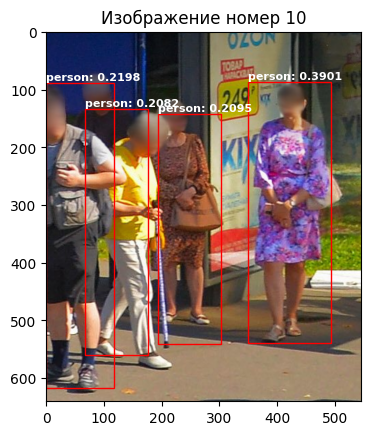

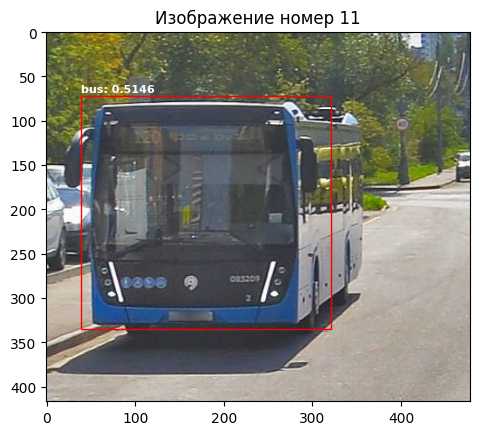

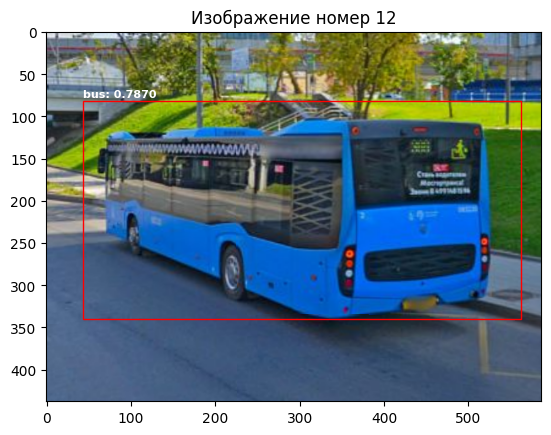

In [14]:

classes = sorted([
    'person', 'bird', 'cat', 'cow', 'dog', 'horse', 'sheep',
    'aeroplane', 'bicycle', 'boat', 'bus', 'car', 'motorbike', 'train',
    'bottle', 'chair', 'diningtable', 'pottedplant', 'sofa', 'tvmonitor'
])

model.eval()

dir_path = Path("test_data")
for i, img_path in enumerate(dir_path.iterdir()):

    img = Image.open(img_path).convert("RGB")

    _, pred_bnboxes = model(transforms(img).unsqueeze(dim=0))
    pred_bnboxes = non_max_suppression(pred_bnboxes, score_threshold=0.2, iou_threshold=0.45)
    w, h = img.size

    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(f"Изображение номер {i+1}")

    for pred_bnbox in pred_bnboxes[0]:
        pred_bnbox = pred_bnbox.detach().to("cpu").numpy() * [w,h,w,h,1,1]

        bnbox_coord = pred_bnbox[:4]
        conf = pred_bnbox[4]
        cls_idx = int(pred_bnbox[5])

        rect = get_rect(pred_bnbox)
        ax.add_patch(rect)

        ax.text(pred_bnbox[0], pred_bnbox[1] - 5, f"{classes[cls_idx]}: {conf:.4f}", 
                color='white', fontsize=8, fontweight='bold')

    plt.show()
    plt.close()

